## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from imports import *
from torch_imports import *
from pt_models import *
from column_data import *
from fast_gen import *
from layer_optimizer import *

In [2]:
path='/data/datasets/movielens/ml-latest-small/'

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Collaborative filtering

In [5]:
val_idxs = get_cv_idxs(len(ratings), cv_idx=0)
wd=2e-4
n_factors = 50

In [6]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

In [6]:
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [7]:
learn.fit(1e-2, 1, wds=wd, cycle_len=3)

[ 0.826276  0.805173]


[ 0.754313  0.761645]


[ 0.530912  0.760102]



In [10]:
preds = learn.predict()

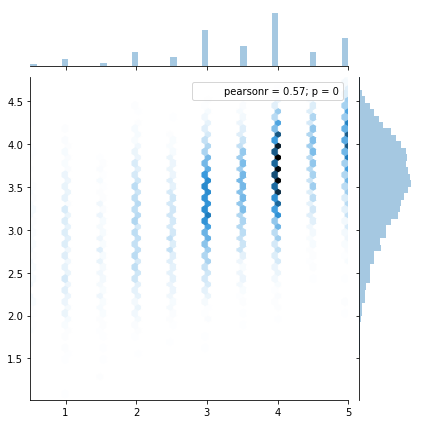

In [43]:
y=learn.data.val_y.numpy().squeeze()
sns.jointplot(y, preds, kind='hex');

### Dot product example

In [10]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [11]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [12]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

In [13]:
class DotProduct(nn.Module):
    def forward(self, u, m):
        return (u*m).sum(1)

In [14]:
model=DotProduct()

In [15]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model

In [7]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [82]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, users, movies):
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [23]:
data = ColumnarModelData.from_data_frame(path, val_idxs, ratings, 
                                         ['userId', 'movieId'], 'rating', 64)

In [118]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [119]:
fit(model, data, 3, F.mse_loss, opt)

[ 1.648317  1.638991]


[ 1.098207  1.302216]


[ 0.914312  1.227468]


In [120]:
set_lrs(opt, 0.01)

In [121]:
fit(model, data, 3, F.mse_loss, opt)

[ 0.708388  1.146384]


[ 0.705547  1.135727]


[ 0.681105  1.131034]


### Bias

In [7]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [8]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, users, movies):
        um = self.u(users)* self.m(movies)
        res = um.sum(1) + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [9]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.Adam(model.parameters(), 1e-2, weight_decay=wd)

In [10]:
data = cf.get_data(val_idxs, 64)

In [11]:
fit(model, data, 1, F.mse_loss, opt)

[ 0.794611  0.81813 ]



In [12]:
set_lrs(opt, 1e-3)

In [13]:
fit(model, data, 3, F.mse_loss, opt)

[ 0.626579  0.783284]


[ 0.612464  0.770777]


[ 0.576384  0.765361]



### Mini net

In [32]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, 10)
        self.lin2 = nn.Linear(10, 1)
        
    def forward(self, users, movies):
        x = F.dropout(torch.cat([self.u(users),self.m(movies)], dim=1), 0.75)
        x = F.dropout(F.relu(self.lin1(x)), 0.75)
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [33]:
wd=5e-4
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [34]:
fit(model, data, 3, F.mse_loss, opt)

[ 0.807436  0.809811]


[ 0.766575  0.788789]


[ 0.776401  0.786128]


[ 0.772507  0.783925]


[ 0.755861  0.782509]



In [35]:
set_lrs(opt, 1e-4)

In [37]:
fit(model, data, 4, F.mse_loss, opt)

[ 0.651059  0.777386]


[ 0.657368  0.774897]


[ 0.621897  0.77398 ]


[ 0.624831  0.77509 ]

